<a href="https://colab.research.google.com/github/elizabeth-pa/clock-constraints/blob/main/Constraint%20Plot%20Generator/Modified_Gravity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install emcee

In [ ]:
import numpy as np
import emcee
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
from IPython.display import display, Math

## MCMC Sampling

In [ ]:
def emcee_sampler(log_post, x0, nburn=300, steps=10000, **kwargs):

    mnwalkers, mndim = x0.shape

    sampler = emcee.EnsembleSampler(mnwalkers,
                                    mndim,
                                    log_post)
    sampler.run_mcmc(x0, nburn, progress=True,tune=True)
    state = sampler.get_chain()[-1, :, :]
    sampler.reset()
    print('Finished initial run, burn-in dropped and starting real run')
    sampler.run_mcmc(state, steps, progress=True,tune=True)

    return sampler.get_log_prob(), sampler.get_chain()

def big_sampler(x,y,sigma_y,theoretical_waveform, theta0, log_prior=lambda _:0.0, nburn=300, steps=3000):
    def log_posterior(theta):
        res=np.abs(y-theoretical_waveform(x,theta))/sigma_y
        return -2*np.sum(res**2)/2 #+ log_prior(theta)

    ndim=len(theta0)
    nwalkers=8*ndim
    p0=np.zeros((nwalkers,ndim))
    for i in range(nwalkers):
        p0[i]=theta0*np.random.normal(loc=1.0, scale=0.001, size=ndim)

    return emcee_sampler(log_posterior, p0, nburn=nburn, steps=steps)

def my_priors(pars):
    if pars[0]<0: #or pars[1]<0 or pars[2]<0 or pars[2]>2*np.pi:
        return -np.inf
    return 0.

## Modeling Signal in the Frequency domain

In [ ]:
# A*sin(omega*t+phi)

def hFA(f, pars = np.array([5e-16])):
    A = pars[0]
    omega = 2*np.pi/Ts
    phi = 0.

    return (1/dt) * A * np.exp(-2j * np.pi * f * T) * (omega * np.cos(omega * T + phi) - np.exp(2j * np.pi * f * T) * (omega * np.cos(phi) +
           2j * np.pi * f * np.sin(phi)) + 2j * np.pi * f * np.sin(omega * T + phi)) / (4 * np.pi * np.pi * f**2 - omega * omega)

## Generate Data using Two Atomic Clocks



1.   Determine the characteristics of your dataset e.g. number of years, sampling rate etc.
2.   Generate white and pink noise.
3. Define the power spectral density coefficients of your clock (white and pink noise).
4. Combine PSD of the noise from the two clocks and factor in the sensitivity coefficients according to the formula:
$$
\frac{\Delta R}{R} = \left( K_{X,1} - K_{X,2} \right)\frac{\Delta X}{X}
$$

5. Generate a signal to inject into the noise.
6. Add the signal to the noise to produce the dataset to be passed to the MCMC framework.



In [ ]:
''' Dataset Characteristics '''
########## input ###########
Ts = 86400*365
nyr = 3.01
T= Ts * nyr
dt = 1
N = int(T / dt)

''' Frequency discretization '''

freqs = fftfreq(N, dt)[0:N//2]
fredd = freqs[freqs<5e-6]
fred = fredd[1:]

''' Noise generation '''

# Clock 1  ########## input ###########
h0a = 3e-33
hm1a = 7.2e-37
K1 = 0.

# Clock 2  ########## input ###########
h0b = 8e-28
hm1b = 2.8e-32
K2 = 1.

# Combination

h0 = h0a + h0b
hm1 = hm1a + hm1b
Ktot = abs(K2 - K1)

def noise_PSD(f):
    return (h0 + hm1 / f) / Ktot

noise = np.sqrt(noise_PSD(fred) * N) * np.exp(-2j * np.pi * np.random.uniform(size = len(fred)))


''' Signal generation '''

myparsA = np.array([5e-16])
signalA = hFA(fred, pars = myparsA)

''' Error samples '''

signoisef = np.abs(noise)

''' Data generation '''

dataA = signalA + noise

## Apply MCMC to Data

 Run the MCMC to fit the parameters of the two models to the generated dataset.

In [ ]:
print('MCMC run for model d=A*sin(omega*t)')
pdf_and_chain_fA=big_sampler(fred,dataA,signoisef,hFA,myparsA*1.1,steps=3000,log_prior=my_priors)
chains_fA=pdf_and_chain_fA[1]
samplesA=chains_fA.reshape(-1,chains_fA.shape[-1]).flatten()
samples_rescaledA=samplesA-np.mean(samplesA)+myparsA

MCMC run for model d=A*sin(omega*t)


100%|██████████| 300/300 [00:00<00:00, 615.65it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 3000/3000 [00:04<00:00, 611.24it/s]


## Fisher Information Matrix Computation

In [ ]:
''' Fisher computation '''
from scipy.integrate import simps

Fish_integrandaA=2*(np.abs(hFA(fred,pars=np.array([1.])))**2)/noise_PSD(fred)
FAAfine=simps(Fish_integrandaA,fred)
samples_fishA=np.random.normal(loc=myparsA[0], scale=1/np.sqrt(FAAfine), size=samplesA.shape[0]).reshape((samplesA.shape[0],1))

<ipython-input-7-87e735dee107>:5: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  FAAfine=simps(Fish_integrandaA,fred)


## Plot the Posterior Distributions for both the Fisher approximation and the MCMC samples for both models.

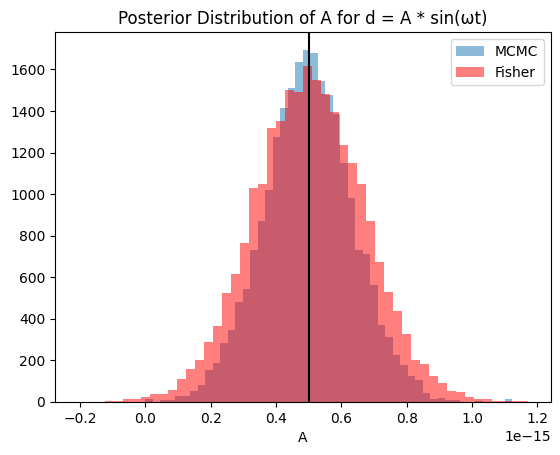

MCMC stdev on A: 1.3535186085364808e-16
Fisher stdev on A: 1.6759325356185395e-16


In [ ]:
plt.title('Posterior Distribution of A for d = A * sin(ωt)')

plt.hist(samples_rescaledA,alpha=0.5,bins=50,label='MCMC')
plt.hist(samples_fishA,color='r',alpha=0.5,bins=50,label='Fisher')
plt.axvline(x=myparsA[0],c='k')
plt.xlabel('A')
plt.legend()
plt.show()
print('MCMC stdev on A:',np.sqrt(np.var(samplesA)))
print('Fisher stdev on A:',np.sqrt(1/FAAfine))

In [ ]:
sigma_A = np.sqrt(np.var(samplesA))

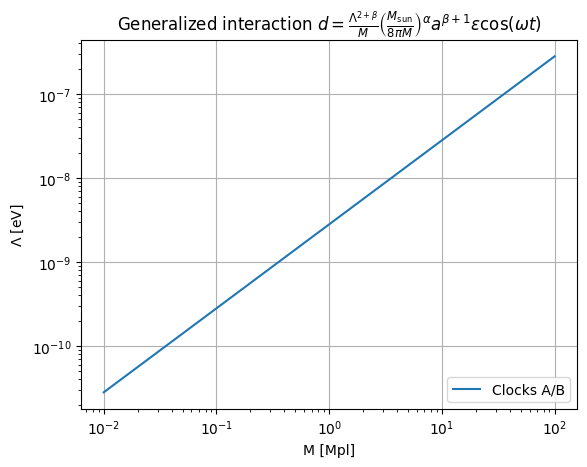

<IPython.core.display.Math object>

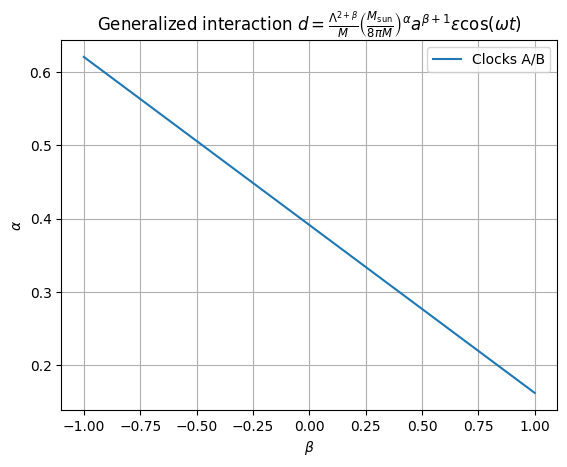

<IPython.core.display.Math object>

In [ ]:
####### PLOTTER general interaction ###########

'''

The model is d = Lambda^(2+b) * (r^(b+1))/(b+1) * (Msun/4pi)^a * M^(-a-1)


'''

# Constants
rhoDE = (2.4e-3) ** 4
rhoDM = 2.6e-6
Msun = 1.12e66
AUev = 1.21e17
eps = 0.0167
hbar = 4.135667696e-15 / (2 * np.pi)
Mpl = 1.22e28
A0f = 2e-18
om0f = 1.99e-7


clock_pair_name = 'Clocks A/B'  # Adjust this name as needed

# Lambda function
def Lambda_of_M(M, alp=0.5, bet=-0.5):
    return (M * (Msun / (8 * np.pi * M)) ** (-alp) * AUev ** (-1 - bet) * sigma_A / eps) ** (1 / (2 + bet))

# M range
M_range = np.logspace(-2, 2)

# Plot for Lambda of M
plt.loglog(M_range, Lambda_of_M(M_range * Mpl), label=clock_pair_name)
plt.title('Generalized interaction ' + r"$d=\frac{\Lambda^{2+\beta}}{M}\left(\frac{M_{\rm sun}}{8\pi M}\right)^{\alpha}a^{\beta+1}\epsilon\cos(\omega t)$")
plt.xlabel(r"M [Mpl]")
plt.ylabel(r"$\Lambda$ [eV]")
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Display equation for alpha and beta
display(Math(r'\text{Here we have fixed }\alpha=1/2 \text{ and }\beta=-1/2'))

# Alpha as a function of beta
def alp_of_bet(bet, M=Mpl, Lam=2e-9):
    return np.log(M * AUev ** (-1 - bet) * Lam ** (-2 - bet) * sigma_A / eps) / np.log(Msun / (8 * np.pi * M))

# Beta range
bet_range = np.linspace(-1, 1)

# Plot for alpha as a function of beta
plt.plot(bet_range, alp_of_bet(bet_range), label=clock_pair_name)
plt.title('Generalized interaction ' + r"$d=\frac{\Lambda^{2+\beta}}{M}\left(\frac{M_{\rm sun}}{8\pi M}\right)^{\alpha}a^{\beta+1}\epsilon\cos(\omega t)$")
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\alpha$")
plt.legend(loc='upper right')
plt.grid()
plt.show()

# Display equation for fixed M and Lambda
display(Math(r'\text{Here we have fixed }M=M_{\rm pl} \text{ and }\Lambda=2\times 10^{-9}'))


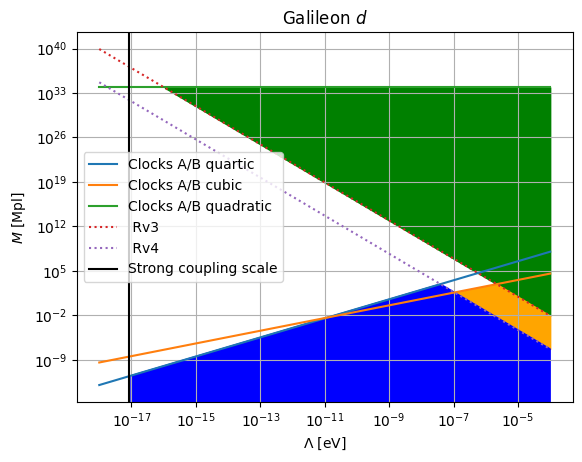

In [ ]:
####### PLOTTER chameleon ###########

'''

The model is d

0<c4<2/3

'''

# Constants
rhoDE = (2.4e-3) ** 4
rhoDM = 2.6e-6
Msun = 1.12e66
AUev = 1.21e17
eps = 0.0167
hbar = 4.135667696e-15 / (2 * np.pi)
Mpl = 1.22e28
A0f = 2e-18
om0f = 1.99e-7


# Functions
def M4(Lam, c4):
    return ((AUev * eps * Lam ** 2 / sigma_A) ** 3 * Msun / (8 * np.pi * c4)) ** (1 / 4)

def M3(Lam):
    return ((eps / sigma_A) ** 2 * (Msun * Lam ** 3 * AUev / (8 * np.pi))) ** (1 / 3)

def M2(Lam):
    return (Msun * eps / (4 * np.pi * sigma_A * AUev)) * (1. + Lam * 0.)

def M_Rv3(Lam):
    return 2 * Msun / (4 * np.pi * (Lam * AUev) ** 3)

def M_Rv4(Lam, c4):
    return M_Rv3(Lam) * (c4 / 2) ** (1 / 2)

# Constant c4
c4_set = 2 / 3 * 1e-10

# Lambda range
Lam_range = np.logspace(-12, 2, 200) * 1e-6

# Calculate ranges
M4_range = M4(Lam_range, c4_set) / Mpl
M3_range = M3(Lam_range) / Mpl
M2_range = M2(Lam_range) / Mpl
M_Rv3_range = M_Rv3(Lam_range) / Mpl
M_Rv4_range = M_Rv4(Lam_range, c4_set) / Mpl

# Plot
plt.loglog(Lam_range, M4_range, label=clock_pair_name + ' quartic')
plt.loglog(Lam_range, M3_range, label=clock_pair_name + ' cubic')
plt.loglog(Lam_range, M2_range, label=clock_pair_name + ' quadratic')
plt.loglog(Lam_range, M_Rv3_range, linestyle='dotted', label=' Rv3')
plt.loglog(Lam_range, M_Rv4_range, linestyle='dotted', label=' Rv4')
plt.axvline(x=1 / AUev, color='k', label='Strong coupling scale')

# Fill regions based on comparisons
Lam_M2_Rv3 = Lam_range[M2(Lam_range) > M_Rv3(Lam_range)]
Lam_M3_Rv4 = Lam_range[M3(Lam_range) > M_Rv4(Lam_range, c4_set)]
Lam_M4_Rv4 = Lam_range[Lam_range > 1 / AUev]

plt.fill_between(Lam_M2_Rv3, M2(Lam_M2_Rv3) / Mpl, M_Rv3(Lam_M2_Rv3) / Mpl, color='green')
plt.fill_between(Lam_M3_Rv4, np.minimum(M3(Lam_M3_Rv4) / Mpl, M_Rv3(Lam_M3_Rv4) / Mpl), M_Rv4(Lam_M3_Rv4, c4_set) / Mpl, color='orange')
plt.fill_between(Lam_M4_Rv4, 0 * Lam_M4_Rv4, np.minimum(M_Rv4(Lam_M4_Rv4, c4_set) / Mpl, M4(Lam_M4_Rv4, c4_set) / Mpl), color='blue')

# Title, labels, and plot settings
plt.title('Galileon ' + r"$d$")
plt.xlabel(r"$\Lambda$ [eV]")
plt.ylabel(r"$M$ [Mpl]")
plt.legend(loc='center left')
plt.grid()
plt.show()


black line -dashed